# Project 1: Assembling Genes

   <div class="alert alert-block alert-danger">
    <center>Due: <b>Monday, September 5, 8:59pm</b>.</center> 
   </div>
   
   <div class="alert alert-block alert-warning">
   <center>
       <b>Collaboration and Resource Policy</b>
    </center>
    
For this assignment, you are encouraged to work with one other person satisfying the constraints from Class 2. 
You are permitted (actually _encouraged_) to discuss these problems with anyone you want, including other students in the class. If you do discuss the specific questions in the assignment with anyone other than your assignment partner and the course staff, though, you should list them in the _External resources used_ section below.
    
You are welcome to use any resources you want for this assignment, other than ones that would defeat the purpose of the assignment. This means you should not look at answers or code from previous semesters of this course, or from any other students in the class (other than your collaboration with your partner), and if you find code that implements the problem you are being asked to do for the assignment, you should not use that code. You should document all external resource you use that are not part of the course materials in the _External resources used_ section below.
    </div>

**Team submitting this assignment:**  
<div class="alert alert-success">
    <b><em>list each member of your team here, including both your name and UVA computing id</em></b>

Team Members (Names): Alison Lu, Alexander Maksiaev

Team Member UVA Computing IDs: atl9rn, aim4fn

</div>

**External resources used:** 
<div class="alert alert-success">
<em>It is not necessary to list the course materials, but if you used any other resources, including discussing problems with students not on your team, list them here.</em>
    
External Resources Used: http://data-science-sequencing.github.io/Win2018/lectures/lecture6/ (Question 1.2, greedy algorithm), https://training.galaxyproject.org/training-material/topics/assembly/tutorials/algorithms-introduction/slides-plain.html and https://www.cs.jhu.edu/~langmea/resources/lecture_notes/assembly_dbg.pdf (Question 1.3, graphing -- unfortunately the second link has pseudocode for how to create a de Bruijn graph, but we did not realize this before referencing the beginning of the pdf, and we did not use the pseudocode itself), https://www.python.org/doc/essays/graphs/ (Question 1.3, ideas for how to graph), https://cp-algorithms.com/graph/euler_path.html#algorithm (Question 1.3, how to find an Euler path), https://www.geeksforgeeks.org/stack-in-python/ (Question 1.3, how to use a stack in python), Jack the TA (general)

</div>

In this project, we will explore genome assembly—the process of determining the order of nucleotides in DNA from fragmented reads. As you might have studied in the reading assignments, genome assembly can get quite complicated, as problems such as full sequence coverage, finding a good length for reads (the $k$ in $k$-mer), and sequencing errors present challenges for sequencing analysis and accuracy. You can assume perfect coverage for all parts of the assignment and no read errors for the first two questions.


<b>Submission</b>: Please submit the code you wrote to generate your answers for all parts using this form: <a href="https://forms.gle/rNTXfYojTLEQ8idg6"><em>https://forms.gle/rNTXfYojTLEQ8idg6</em></a>. Your answers should be in the Jupyter Notebook, along with your code. Before submission, you should make a copy of your notebook file with the name <i>uvaid1\_uvaid2.ipynb</i> (where <i>uvaidn</i> is each teammates UVA id) so the submitted file identifies you. You and your partner should submit a single file once together. Submission is due 8:59 pm (EST) on Monday, September 5.

## Install basic required packages.

- Install basic required packages, should be run only once. You may need to restart the kernel after this stage.
- Make sure you have [graphviz](https://graphviz.org/download/) installed on your system.
- The second cell adds Graphviz to your path, you may have to change based on where the install folder is.

<b>NOTE: We provide utils.py, which may contain helpful functions for you to use, as well as gvmagic.py, which is a deprecated package to use graphviz within the notebook</b>

In [36]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [37]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

## Genome Assembly

For this part, you're given reads generated while trying to sequence the DNA of a TeleTubby (some unknown organism) with a \textit{very} small genetic code. By answering the following questions, you will learn how to assemble the original genome sequence from sequence reads.

Sequencing data is often stored in FASTQ file format. In TeleTubby.fastq, you will find the data organized in a particular order that repeats every four lines. The first line contains the metadata that encodes the name of the read, the experiment type, the kind of sequencing machine used, etc. The second line is the sequence of bases. The third line functions as a placeholder line. The fourth line is a sequence of base qualities that encode the qualities for the corresponding bases in the sequence line. We will only work with the sequence and quality score lines in this question.

In [38]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import utils
from tqdm import tqdm

#### Question 1.1.1 GC-content

The GC-content (or the ratio of G and C nucleotides) is related to the melting temperature of the DNA double helix. Use the following equation to calculate the melting temperature of DNA for TeleTubby $t_m$ in Celsius:

\begin{equation*}
t_m = 64.9+0.41(\%GC)-\frac{500}{\text{length of sequence}}
\end{equation*}

As a reference, the human genome is known to have between 35%-60% GC-content. 

In [39]:
# Read sequence reads (error-free) from file
sequence_reads, qualities = utils.read_fastq('TeleTubby.fastq')

# Calculate %GC content
length = len(sequence_reads)
gc = 0
total = 0
for gen in sequence_reads:
    for nuc in gen:
        if nuc == 'G' or nuc == 'C':
            gc += 1
        total += 1
gc_content = gc/total

temp = 64.9 + 0.41*gc_content - 500/length

# Print out temperature in Celsius
print(temp)

63.390119453924925


#### Question 1.1.2 Interpreting quality scores

Phred33 quality scores are represented as the character with an ASCII code equal to its value + 33 (to make them easy to print alongside genome sequences). List the top 5 most frequent scores in ASCII symbol as well as their Phredd33 scores in TeleTubby.fastq. You can refer to the [official Illumina website](https://support.illumina.com/help/BaseSpace_OLH_009008/Content/Source/Informatics/BS/QualityScoreEncoding_swBS.htm) to reference the scoring encoding.

What is the average Phred33 score in TeleTubby.fastq?

In [105]:
# Calculate and print average Phred33 score
average = 0
total = 0
for ch in qualities: # Qualities do not hold genes, they hold seemingly random characters
    for c in ch:
        phred33 = ord(c) - 33
        average += phred33
        total += 1
average = average/total
print(average) # Q is ~34.48, 99% accuracy

34.476535836177476


#### Question 1.1.3 Frequency analysis

Looking at repetitions in the sequence can be helpful in estimating the "redudancy" in the organisms. Humand and other evolved animals have a lot of redundancy, while smaller organisms like bacteria have highly packed genomes. One heuristic to estimate this before actually performing the assembly could be looking at how often certain $k$-mers are repeated.

<b>Print out the 3 most frequent k-mers with their frequencies</b>

In [41]:
kmers = {}
for gen in sequence_reads:
    if gen not in kmers:
        kmers[gen] = 1
    else:
        kmers[gen] += 1

kmers3 = []
for key in kmers.keys():
    if kmers[key] != 1: # assumption that 3 most frequent k-mers appear more than once
        if len(kmers3) > 2:
            min = 0
            c = 0
            for i in kmers3:
                if min > kmers[i]:
                    min = kmers[i]
                    c = i
            del kmers3[c]
        kmers3.append(key)

print([f"{i}: {kmers[i]}" for i in kmers3])

['GCTATCGC: 3', 'TATCGCAA: 2', 'CTATCGCA: 2']


### Question 1.2. Greedy approach

One of the approaches to assemble the genome from the given reads is a greedy algorithm. Have a look at the greedy algorithm described on [Wikipedia](https://en.wikipedia.org/wiki/Sequence_assembly#Greedy_algorithm) and answer the following.

#### Question 1.2.1 What would the runtime be of this algorithm, given $n$ $k$-mer reads?

<i>Answer</i>: The runtime would be O(k * n^2) because not only does the algorithm have to compare each k-mer to every other k-mer (a problem which is n^2), it also has to take into account the k in the reads, and multiply each k-mer by k. 

#### Question 1.2.2 Would this algorithm always yield a unique solution?

<i>Answer</i>: No this algorithm would not always yield a unique solution. If fragments share the same overlap, different fragments would be paired each time the algorithm was run.

#### Question 1.2.3 Would this algorithm always yield the <i>right</i> solution?

<i>Answer</i>: No since the right solution is a unique solution. Since the algorithm could potentially return a different solution, it could potentially return a wrong one.

### Question 1.3 Graph-based approaches

Graphs for genome assembly can be constructed in two ways:

- de Bruijn graph: Processing $k-$mers as nodes, with $(k-1)-$mers as edges, and
- Overlap graph: Processing $k-$mers as edges, with $(k-1)-$mers as nodes.

de Bruijn graphs can be processed to find Euler paths, while Overlap graphs can be processed to find Hamiltonian paths. Both of these are valid ways to reconstruct the original genome.

<b>Use one of these two techniques to reconstruct the sequence, and print out your reconstructed sequence. Which method did you pick out of the two, and why? (hint: imagine what would happen when we have millions of reads). Use the k-mers provided in TeleTubby.fastq</b>.

We provide some skeleton code that you may use, but you may also come up with your own solution.

In [55]:
# Read reads into graph -- Use the de Bruijn graph approach, because we have a smaller amount of reads. 

def build_graph(k_mers): # these are 8-mers
    edges = []
    nodes = set(k_mers) # Because we are using de Bruijn, we are processing k-mers as nodes
    new_nodes = set(k_mers) # Make another set of nodes so we can iterate through that and add to the first one without changing the size
    # Split the 8-mers into left and right 7-mers -- that is, (k-1)-mers
    for node in new_nodes:
        edg = [] # Create a miniature list to represent the drawn edge from point A to point B
        left = node[0:(len(node)-1)]
        right = node[1:len(node)]
        edg.append(left)
        edg.append(right)
        edges.append(edg) # Attach the mini-lists to the big edge list
        nodes.add(left) # Don't forget to attach the nodes to the nodes set
        nodes.add(right)
    return nodes, edges

nodes, edges = build_graph(sequence_reads)

print(edges)

[['ATCCGCT', 'TCCGCTA'], ['TTCATGC', 'TCATGCA'], ['GTTTCTC', 'TTTCTCG'], ['ATGTCGA', 'TGTCGAG'], ['TTTCTCG', 'TTCTCGT'], ['CCGCCAA', 'CGCCAAT'], ['AGGGGTT', 'GGGGTTT'], ['ACATATC', 'CATATCG'], ['GGAGTAT', 'GAGTATG'], ['GGATAAC', 'GATAACA'], ['CGCAAAC', 'GCAAACC'], ['TTGTTTC', 'TGTTTCT'], ['TCTCTTT', 'CTCTTTA'], ['AGAAGGG', 'GAAGGGG'], ['TGCAATG', 'GCAATGT'], ['CGGACTC', 'GGACTCT'], ['GGGGTTT', 'GGGTTTT'], ['AACTTAT', 'ACTTATG'], ['ACTACAT', 'CTACATG'], ['GCGCAGG', 'CGCAGGA'], ['CCGCCCT', 'CGCCCTT'], ['GAGATTT', 'AGATTTG'], ['AAAAAGT', 'AAAAGTG'], ['AAACACT', 'AACACTC'], ['TCGTGCC', 'CGTGCCC'], ['CGACATA', 'GACATAT'], ['TGGTATC', 'GGTATCG'], ['TTTGTGC', 'TTGTGCT'], ['AACCTAA', 'ACCTAAG'], ['TTCGATG', 'TCGATGC'], ['ATGTACT', 'TGTACTA'], ['GACTCTT', 'ACTCTTT'], ['TGTGTTA', 'GTGTTAG'], ['TCGACAT', 'CGACATA'], ['ACACTCG', 'CACTCGC'], ['CAATGTC', 'AATGTCG'], ['GCCCGCC', 'CCCGCCA'], ['TAAGAGA', 'AAGAGAG'], ['GCTGTCA', 'CTGTCAT'], ['GAGCAAA', 'AGCAAAA'], ['TAACAAC', 'AACAACT'], ['GCAGTTT', 'CA

In [51]:
# Implement assembly algorithm -- see above

In [52]:
# Print assembled sequence -- see graph below

In [53]:
# Needed to properly visualize graphs
%load_ext gvmagic

The gvmagic extension is already loaded. To reload it, use:
  %reload_ext gvmagic


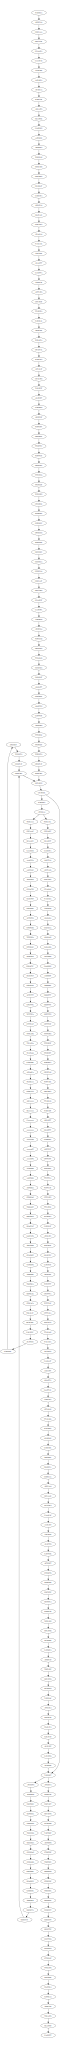

In [54]:
# Helper function to visualize de Bruijn graphs
%dotstr utils.viz_debruijn(nodes, edges)

In [136]:
# Main assembly algorithm -- Create Euler path 

def assemble_sequence(nodes, edges):
    assembled_sequence = ""
    
    # Make a copy of the edges to destroy
    edges2 = edges
    # Make a new list of nodes 
    nodes2 = []
    for node in nodes:
        nodes2.append(node)
            
    # Create an Euler path by finding degree of nodes and adding them to a stack
    # Create a stack for keeping track
    stack = []
    # Add start node
    stack.append(nodes2[0])
    assembled_sequence += stack[0]
    print(assembled_sequence)
    degs = 0
    # Until stack is empty...
    while len(stack) > 0:
        print("here")
        # Get the last thing from the stack, as long as it's not the first thing that was put there
        vert = ""
        if stack[len(stack)-1] == nodes2[0]:
            # If it's the first thing in the stack, tack on its partner's last letter and move on
            for edge in edges2:
                if stack[0] in edge and stack[0] == edge[0]:
                    stack.append(edge[1]) # Add the partner to the stack
                    assembled_sequence += edge[1][len(edge[1])-1] # Add the last character of the partner to the sequence
                    print(assembled_sequence)
        else: # If it's not the first thing that was put there
            for edge in edges2:
                if stack[len(stack)-1] in edge and stack[len(stack)-1] == edge[0]:
                    stack.append(edge[1]) # Add the partner to the stack
                    assembled_sequence += edge[1][len(edge[1])-1] # Add the last character of the partner to the sequence
                    stack.pop()
                    print(assembled_sequence)
            
#                     vert = stack[len(stack)-1]
#                     print(vert)
#         else: # If it's not the first thing in the stack (that is, it's not the very first thing), make it a vertex
#             vert = stack[len(stack)-1]
#             # If the degree is 0, add V to assembled_sequence and pop off stack
#             print(stack)
#             while degs == 0:
#                 print("here too")
#                 for edge in edges2:
#                     if vert in edge and vert != "":
#                         print('hello')
#                         degs = degs + 1
#                     else:
#                         break
#                 if vert != "":
#                     print("vert: " + vert)
#                     assembled_sequence += vert[len(vert)-1]
#                     print("as: " + assembled_sequence)
#                     if len(stack) > 0:
#                         stack.pop()
#                     else:
#                         break
#                 elif degs != 0 and vert != "":
#                     for edge in edges2:
#                         if vert in edge:   
#                             second = edge[len(edge)-1]
#                             edges2.remove(edge)
#                             stack.append(second)
#                         else:
#                             break
#             else:
#                 continue
                
                        # If not, find any edge coming out of V, remove it from the graph, and put the second half of the edge in the stack
            
                    
    
    return assembled_sequence

In [137]:
# Output assembled sequence

assembled_seq = assemble_sequence(nodes, edges)

print(assembled_seq)

AAAAGTG
here
AAAAGTGG
here
AAAAGTGGG
here
AAAAGTGGGG
here
AAAAGTGGGGG
here
AAAAGTGGGGGG
here
AAAAGTGGGGGGG
here
AAAAGTGGGGGGGG
here
AAAAGTGGGGGGGGG
here
AAAAGTGGGGGGGGGG
here
AAAAGTGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
he

here
AAAAGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
here
AAAAGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG

here
AAAAGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG

AAAAGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

## Question 2 - Sequencing SARS-CoV-2 virus

Let's move on from TeleTubbies to real-world organisms. Let's start small- with a variant of the SARS-CoV-2 virus. You're given reads from <i>actual</i> genome sequencing runs in the SARS-CoV2.fastq file provided.

Repeat Question 1.3 on this data. You can re-use your implementation and simply run it on the new data. Print out your reconstructed sequence to a file "output.txt". For this part, we will still assume that all the reads are error-free. Set $k=25$.

In [14]:
# Read sequence reads
sequence_reads_covid, qualities_covid = utils.read_fastq('SARS-CoV2.fastq')

In [526]:
# Read reads into graph
nodes_covid, edges_covid = build_graph(sequence_reads_covid)

In [527]:
# Call main assembly algorithm
assmebled_covid_seq = assemble_sequence(nodes_covid, edges_covid)

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


KeyboardInterrupt: 

In [ ]:
# Write assembled sequence to file

assmebled_seq = "" # Use your assembled genome
with open("covid_overlap.txt", "w") as f:
    f.write(assmebled_seq)

# Question 3- Error-Aware Assembly (Extra Credit)

In the parts above, we assumed error-free reads while assembling $k$-mers. As much as we'd like that, actual reads can (and do) have errors, captured by their Phred scores. For this question, you're given raw, actual reads from sequencing runs (download reads here: https://sra-pub-sars-cov2.s3.amazonaws.com/sra-src/SRR11528307/ABS2-LN-R1_cleaned_paired.fastq.gz).  Given these reads and their Phred33 scores, can you assemble the genome?

<b>Print out your assembled sequence, along with a brief explanation of how your algorithm works</b>

This is an open-ended question. You are free to use any approach to deal with the issue. Make sure you provide your code, along with any assumptions you may have, in the cells below.

In [106]:
sequences, q = utils.read_fastq('ABS2-LN-R1_cleaned_paired.fastq')
print(len(sequences))

719807


In [107]:
# Calculate and print average Phred33 score

average = 0
total = 0
for ch in q:
    for c in ch:
        phred33 = ord(c) - 33
        average += phred33
        total += 1
average = average/total
print(average) # Q is ~35.98, 99% accuracy

35.97869277719108
